In [3]:
import pandas as pd
import json
import os
from sklearn.metrics import accuracy_score, classification_report

In [4]:
!pip install langchain

In [5]:
# Adjusted prompt text
prompt_text = """
You are a forensic expert specialized in analyzing images to detect deepfakes. Your task is to thoroughly evaluate the provided image based on the following steps and synthesize your findings to determine if the image is a deepfake:

1. Facial Features
2. Skin Texture and Tone
3. Image Quality and Artifacts
4. Lighting and Shadows
5. Background and Context
6. Geometric Consistency
7. Hair and Accessories
8. Metadata Analysis (if available)
9. Overall Authenticity

**Your observations must be concise and relevant**. Focus on specific anomalies or notable elements for each category. If no issues are found, state that explicitly.

Your response must follow the analysis structure and ensure accuracy in your observations.

**IMPORTANT INSTRUCTIONS:**

- **Respond strictly in JSON format. Do not include any other output or text outside of the JSON structure.**
- **Do not add explanations, introductions, or any text before or after the JSON.**
- **Your entire response should be a single JSON object matching the specified format.**

The JSON response must adhere to the following format:

{format_instructions}
"""

In [6]:
!pip install --upgrade langchain-together

In [7]:
import re
import json
from pydantic import ValidationError
from pydantic import BaseModel, Field, ValidationError
from langchain_core.output_parsers import JsonOutputParser
from langchain_together import ChatTogether
import requests
import base64


class PredictionResponse(BaseModel):
    result: str = Field(
        ...,
        alias="Result",
        description="The prediction result, either 'Fake' or 'Real'",
    )
    confidence: float = Field(
        ...,
        alias="confidence",
        ge=0.0,
        le=1.0,
        description="The confidence score between 0 and 1",
    )
    reason: str = Field(
        ...,
        alias="reason",
        description="A concise explanation for why the image is classified as Fake or Real",
    )

    class Config:
        allow_population_by_field_name = True


# JSON 추출 함수
def extract_json(response_text):
    """
    Cleans and fixes invalid JSON responses.
    Removes invalid control characters and fixes multi-line strings in the reason field.
    """
    try:
        # JSON만 추출
        json_match = re.search(r"\{[\s\S]*\}", response_text)
        if json_match:
            json_text = json_match.group()

            # 잘못된 따옴표 수정
            json_text = json_text.replace("“", '"').replace("”", '"')

            # reason 필드의 개행문자와 불필요한 기호 제거
            json_text = re.sub(r"- ", "", json_text)  # 불필요한 '-' 제거
            json_text = re.sub(r"\n\s*", " ", json_text)  # 개행 및 들여쓰기 제거

            # JSON 디코딩
            return json.loads(json_text)
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
    return None


parser = JsonOutputParser(pydantic_object=PredictionResponse)
format_instructions = parser.get_format_instructions()

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.12\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
  warnings.warn(message, UserWarning)


In [8]:
# CSV 파일 읽기
file_path = "Test_dataset.csv"
df = pd.read_csv(file_path)

# 이미 처리된 이미지를 기록할 파일
processed_file = "processed_images.txt"

# 처리된 이미지 파일 목록 불러오기
if os.path.exists(processed_file):
    with open(processed_file, "r") as f:
        processed_images = set(line.strip() for line in f)
else:
    processed_images = set()

# 결과를 저장할 데이터프레임 생성
results = []

In [ ]:
from langchain.schema import HumanMessage

# 각 이미지 처리

for index, row in df.iterrows():

    image_url = row["url"]

    file_name = row["FileName"]

    label = row["Label"]


    # Skip if already processed
    if file_name in processed_images:

        print(f"Skipping already processed image: {file_name}")
        continue


    print(f"\nProcessing image: {image_url}")


    # Download the image and convert it to base64

    try:

        response_img = requests.get(image_url)

        if response_img.status_code == 200:

            image_content = response_img.content

            # Convert the image to base64

            image_base64 = base64.b64encode(image_content).decode("utf-8")
        else:

            print(f"Failed to download image: {image_url}")
            continue

    except Exception as e:

        print(f"Error downloading image {file_name}: {e}")
        continue

    # API 요청
    # Prepare the message content
    messages = [
        HumanMessage(
            content=[
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                },
            ]
        )
    ]

    try:

        llm = ChatTogether(

            model="meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo",

            api_key="d32984692bb2a2978db793029c7b659a41cef3e059899b3df433359b714533e3",

            # messages=[

            #     {"role": "system", "content": system_message},

            #     {

            #         "role": "user",

            #         "content": [

            #             {"type": "text", "text": prompt},

            #             {"type": "image_url", "image_url": {"url": image_url}},

            #         ],

            #     },

            # ],

            temperature=0,

        )


        # Run the chain to get the response

        try:
            response = llm.invoke(messages)
        except Exception as e:
            print(f"Error processing image {file_name}: {e}")
            continue


    except Exception as e:

        print(f"Error initializing LLM for image {file_name}: {e}")

        continue

    # Extract the content from the LLM response
    response_text = response.content if hasattr(response, "content") else response


    # Parse the LLM's response using the parser
    try:
        prediction = parser.parse(response_text)
        model_result = prediction.result
        confidence = prediction.confidence
        reason = prediction.reason
    except Exception as e:
        print(f"Error parsing response for {file_name}: {e}")
        model_result = "Unknown"
        confidence = 0.0
        reason = "Parsing error"

    # Map model_result to model_label
    if model_result.lower() == "fake":
        model_label = 1
    elif model_result.lower() == "real":
        model_label = 0
    else:
        model_label = -1

    # Append the results
    results.append(
        {
            "FileName": file_name,
            "url": image_url,
            "Label": label,
            "모델_Label": model_label,
            "Confidence": confidence,
            "Reason": reason,
        }
    )

    # Record the processed image
    with open(processed_file, "a") as f:
        f.write(f"{file_name}\n")


Processing image: https://raw.githubusercontent.com/DongDoRoDongDong/deepfake_detection_test_data/main/test/44320008_1988-06-06_2012.jpg


In [ ]:
# 리스트를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 기존 결과 병합
output_file = "Test_dataset_results.csv"
if os.path.exists(output_file) and os.stat(output_file).st_size > 0:
    try:
        existing_results = pd.read_csv(output_file)
    except pd.errors.EmptyDataError:
        existing_results = pd.DataFrame()
else:
    existing_results = pd.DataFrame()

results_df = pd.concat(
    [existing_results, results_df], ignore_index=True
).drop_duplicates(subset=["FileName"])

# 결과 저장
results_df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"\nProcessed results saved to {output_file}")


Processed results saved to Test_dataset_results.csv



Model Accuracy: 45.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        42
           1       0.00      0.00      0.00        50

    accuracy                           0.46        92
   macro avg       0.23      0.50      0.31        92
weighted avg       0.21      0.46      0.29        92


Confusion Matrix:
[[42  0]
 [50  0]]


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

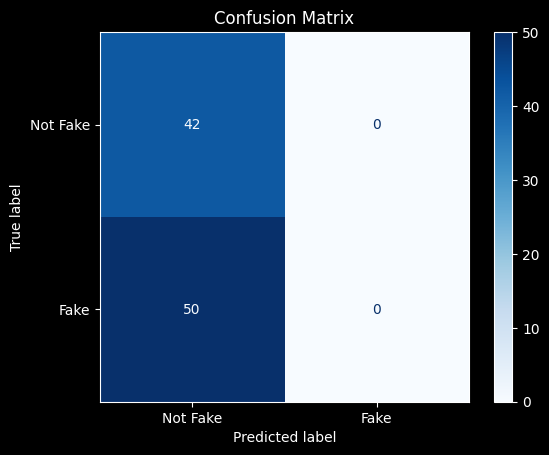

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 정확도 계산
valid_results = results_df[results_df["모델_Label"] != -1]  # 유효한 결과만 필터링
accuracy = accuracy_score(valid_results["Label"], valid_results["모델_Label"])
print(f"\nModel Accuracy: {accuracy:.2%}")

# 추가적인 정밀도, 재현율, F1 점수 계산
print("\nClassification Report:")
print(classification_report(valid_results["Label"], valid_results["모델_Label"]))

# 혼동 행렬 계산
cm = confusion_matrix(valid_results["Label"], valid_results["모델_Label"])
print("\nConfusion Matrix:")
print(cm)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fake", "Fake"])
disp.plot(cmap="Blues")  # 색상 지도 설정
plt.title("Confusion Matrix")
plt.show()